Number of words included in the lists of phrases: 783
Average length of phrases: 4.11
Standard deviation of phrase lengths: 0.94


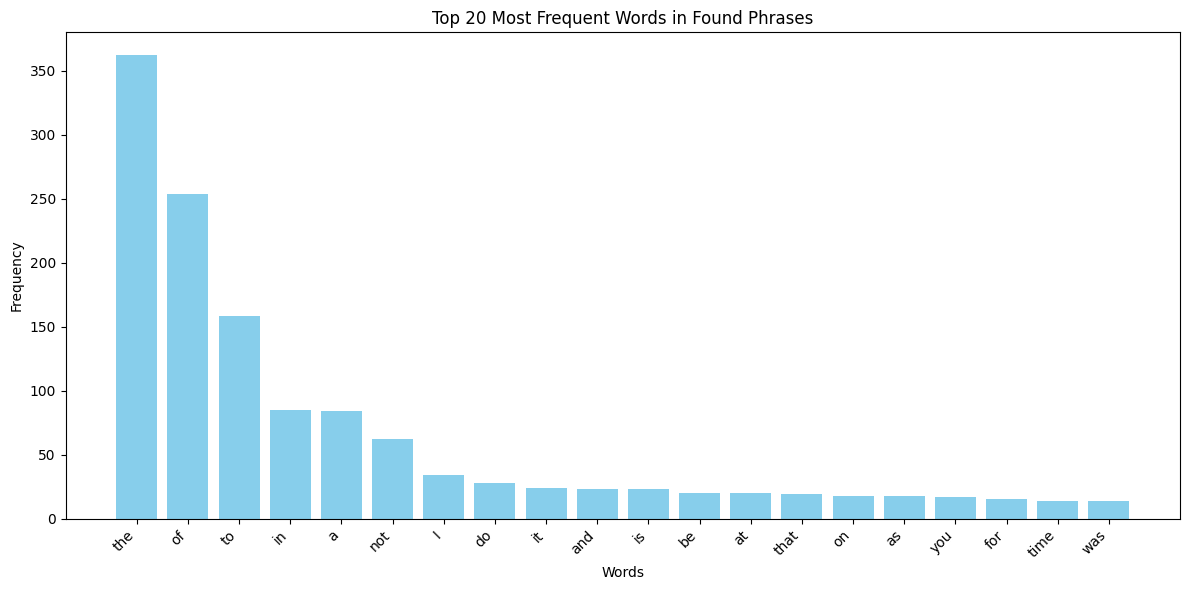

Processed phrases have been saved to Oxford_1035_google_ngram.csv.


In [12]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def read_and_concatenate_csv(file_paths):
    """
    Reads multiple CSV files and concatenates them into a single dataframe.
    Assumes all CSVs have the same header.
    """
    all_dfs = []
    for file in file_paths:
        df = pd.read_csv(file)
        all_dfs.append(df)
    
    concatenated_df = pd.concat(all_dfs, ignore_index=True)
    concatenated_df.columns = ['phrase', 'frequency']
    return concatenated_df

def filter_offensive_and_repetitive_phrases(df):
    """
    Filters out phrases that contain offensive words or phrases with three or more occurrences of the same word.
    """
    # Define offensive words
    offensive_words = ['bitch', 'fuck', 'shit']
    
    # Filter out offensive phrases
    offensive_pattern = '|'.join([fr'\b{word}\b' for word in offensive_words])
    df = df[~df['phrase'].str.contains(offensive_pattern, case=False, na=False)]
    
    # Filter out phrases with three or more occurrences of the same word
    def has_repetitive_words(phrase):
        words = phrase.lower().split()
        word_counts = {word: words.count(word) for word in set(words)}
        return any(count >= 3 for count in word_counts.values())
    
    df = df[~df['phrase'].apply(has_repetitive_words)]
    
    return df

def find_longest_phrase(word, concatenated_df, fetched_phrases):
    """
    Finds the best phrase containing the word based on the new filtering criteria.
    """
    # Filter phrases containing the word
    matching_phrases = concatenated_df[concatenated_df['phrase'].str.contains(fr'\b{word}\b', case=False, na=False)]
    
    # Exclude already fetched phrases
    matching_phrases = matching_phrases[~matching_phrases['phrase'].isin(fetched_phrases)]
    
    if matching_phrases.empty:
        return None

    # Apply additional filters for offensive and repetitive words
    matching_phrases = filter_offensive_and_repetitive_phrases(matching_phrases)
    
    if matching_phrases.empty:
        return None

    # Filter out phrases that end with "'s" and are less than 5 words in length
    matching_phrases['phrase_length'] = matching_phrases['phrase'].str.split().apply(len)
    matching_phrases = matching_phrases[
        ~((matching_phrases['phrase'].str.endswith("'s")) & (matching_phrases['phrase_length'] < 5))
    ]

    if matching_phrases.empty:
        return None
    
    # Prioritize phrases that do not end with "of the" and do not contain commas
    preferred_phrases = matching_phrases[
        ~matching_phrases['phrase'].str.contains(r'of the$', case=False) &
        ~matching_phrases['phrase'].str.contains(',', na=False)
    ]

    if not preferred_phrases.empty:
        # Sort preferred phrases by length and frequency (descending) if multiple remain
        preferred_phrases = preferred_phrases.sort_values(by=['phrase_length', 'frequency'], ascending=[False, False])
        chosen_phrase = preferred_phrases.iloc[0]['phrase']
    else:
        # If no preferred phrase is found, choose the highest frequency phrase from all matching phrases
        sorted_phrases = matching_phrases.sort_values(by=['frequency', 'phrase_length'], ascending=[False, False])
        chosen_phrase = sorted_phrases.iloc[0]['phrase']
    
    return chosen_phrase
def clean_phrase(phrase):
    """
    Cleans the phrase by replacing certain contractions and removing unnecessary punctuation.
    """
    phrase = re.sub(r"\s+'ve\b", " have", phrase)  # Replace "'ve" with " have"
    phrase = re.sub(r"\s+'ll\b", " will", phrase)  # Replace "'ll" with " will"
    phrase = re.sub(r"\s*,\s*", " ", phrase)       # Remove all " ,"
    return phrase

def process_word_list(word_list_file, concatenated_df):
    """
    Processes a list of words and finds the most suitable phrase for each.
    """
    word_list = pd.read_csv(word_list_file, header=None)
    word_list.columns = ['word']
    
    found_phrases = []
    fetched_phrases = set()
    
    for _, row in word_list.iterrows():
        word = row['word']
        phrase = find_longest_phrase(word, concatenated_df, fetched_phrases)
        
        if phrase:
            # Remove spaces before apostrophes in the chosen phrase
            # phrase_cleaned = re.sub(r"\s+'", "'", phrase)
            phrase_cleaned = clean_phrase(phrase)
            found_phrases.append((word, phrase_cleaned))
            fetched_phrases.add(phrase)
        else:
            found_phrases.append((word, "unfound"))
    
    return found_phrases

def calculate_statistics(found_phrases):
    """
    Calculates the statistics: number of unique words, average length of phrases, and standard deviation of lengths.
    """
    all_words = set()
    phrase_lengths = []
    
    for word, phrase in found_phrases:
        if phrase != "unfound":
            # Split the phrase into individual words and add to the set of all words
            words_in_phrase = phrase.split()
            all_words.update(words_in_phrase)
            
            # Record the length of the phrase
            phrase_lengths.append(len(words_in_phrase))
    
    # Calculate statistics
    unique_word_count = len(all_words)
    average_length = np.mean(phrase_lengths) if phrase_lengths else 0
    std_dev_length = np.std(phrase_lengths) if phrase_lengths else 0
    
    return unique_word_count, average_length, std_dev_length

def plot_top_20_words_histogram(found_phrases):
    """
    Plots a histogram of the top 20 most frequent words in the found phrases.
    """
    # Flatten all words from the found phrases into a single list
    all_words = [word for _, phrase in found_phrases if phrase != "unfound" for word in phrase.split()]
    
    # Count the frequency of each word
    word_counts = Counter(all_words)
    
    # Get the top 20 most frequent words
    top_20_words = word_counts.most_common(20)
    
    # Extract words and their counts for plotting
    words, counts = zip(*top_20_words)
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title('Top 20 Most Frequent Words in Found Phrases')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def export_to_csv(found_phrases, output_file):
    """
    Exports the list of found phrases to a CSV file.
    """
    df = pd.DataFrame(found_phrases, columns=['phrase', 'word'])
    df.to_csv(output_file, index=False)

if __name__ == "__main__":
    # 1. Concatenate CSV files into a single dataframe
    csv_files = glob.glob("./*grams_english*.csv")  # Replace with your directory path
    concatenated_df = read_and_concatenate_csv(csv_files)
    
    # 2. Process the word list and find phrases
    word_list_file = "../Oxford 1035 Export pure_ext.csv"  # Replace with the path to your word list CSV file
    found_phrases = process_word_list(word_list_file, concatenated_df)
    
    # 3. Calculate statistics for found phrases
    num_words_unique, average_length, standard_deviation = calculate_statistics(found_phrases)
    print(f"Number of words included in the lists of phrases: {num_words_unique}")
    print(f"Average length of phrases: {average_length:.2f}")
    print(f"Standard deviation of phrase lengths: {standard_deviation:.2f}")
    
    # 4. Plot the histogram of top 20 most frequent words
    plot_top_20_words_histogram(found_phrases)

    # 3. Export found phrases to a CSV file
    output_file = "Oxford_1035_google_ngram.csv"  # Replace with your desired output file path
    export_to_csv(found_phrases, "./raw_" + output_file)
    export_phrases = found_phrases.copy()
    # eliminate the unfound phrases
    export_phrases = [phrase for phrase in export_phrases if phrase[1] != "unfound"]
    # make phrase the first column
    export_phrases = [(phrase[1], phrase[0]) for phrase in export_phrases]
    export_to_csv(export_phrases, "./" + output_file)

    print(f"Processed phrases have been saved to {output_file}.")
### 2-gram added (732 found 1000+ words)